### Chatbot Memory

- 상태 저장 방식
- 상태 쿼리 방식

##### State Graph

In [6]:
from typing import TypedDict
from langgraph.graph import END, START, StateGraph

class InputState(TypedDict):
    string_value: str
    numeric_value: int


def modify_state(input: InputState):
    print(f"Current value: {input}")
    return input

graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge(START, "branch_a")
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

mygraph = graph.compile()

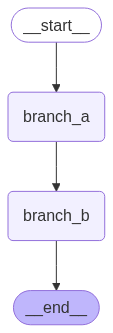

In [4]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        mygraph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [5]:
mygraph.invoke({"string_value": "a"})

Current value: {'string_value': 'a'}
Current value: {'string_value': 'a'}


{'string_value': 'a'}

In [1]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages([
    ("system", "당신은 유능한 에이전트입니다. 모든 질문에 최선을 다해 답을 주세요."),
    ("placeholder", "{messages}"),
])

model = ChatOpenAI(model_name="gpt-4o-mini")

chain = prompt | model

response = chain.invoke({
    "messages": [
        ("human", "다음의 문장을 불어로 번역해주세요: 나는 머신러닝을 공부하고 있습니다."),
        ("ai", "J'adore programmer."),
        ("human", "방금 무슨 이야기를 했어?"),
    ],
})

print(response.content)


죄송합니다. 이전에 제가 전달한 답변은 원래 질문과 관련이 없는 것이었습니다. 제가 잘못 이해했습니다. 원래 질문인 "나는 머신러닝을 공부하고 있습니다."를 불어로 번역하면 "Je suis en train d'étudier l'apprentissage automatique." 가 됩니다.


In [10]:
from typing import Annotated, TypedDict

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.checkpoint.memory import MemorySaver


class State(TypedDict):
    messages: Annotated[list, add_messages]


builder = StateGraph(State)

model = ChatOpenAI(model_name="gpt-4o-mini")


def chatbot(state: State):
    answer = model.invoke(state["messages"])
    return {"messages": [answer]}


# Add the chatbot node
builder.add_node("chatbot", chatbot)

# Add edges
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

# Run the graph
input = {"messages": [HumanMessage("안녕!")]}
for chunk in graph.stream(input):
    print(chunk)


{'chatbot': {'messages': [AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bo2tq0LKzZwQYOtSd5zpddy7xqLNQ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--bec87055-88eb-4886-af06-91247a93de85-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


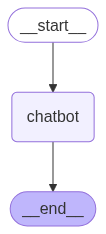

In [11]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [12]:
from typing import Annotated, TypedDict

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.checkpoint.memory import MemorySaver


class State(TypedDict):
    messages: Annotated[list, add_messages]


builder = StateGraph(State)

model = ChatOpenAI(model_name="gpt-4o-mini")


def chatbot(state: State):
    answer = model.invoke(state["messages"])
    return {"messages": [answer]}


builder.add_node("chatbot", chatbot)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# Add persistence with MemorySaver
graph = builder.compile(checkpointer=MemorySaver())

# Configure thread
thread1 = {"configurable": {"thread_id": "1"}}

# Run with persistence
result_1 = graph.invoke({"messages": [HumanMessage("안녕 나의 이름은 헨리야")]}, thread1)
print(result_1)

result_2 = graph.invoke({"messages": [HumanMessage("내 이름이 뭐야?")]}, thread1)
print(result_2)

# Get state
print(graph.get_state(thread1))


{'messages': [HumanMessage(content='안녕 나의 이름은 헨리야', additional_kwargs={}, response_metadata={}, id='ecafddf3-c266-4355-bec2-9d0d0898ed5e'), AIMessage(content='안녕, 헨리야! 만나서 반가워. 어떻게 도와줄 수 있을까?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 17, 'total_tokens': 39, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bo2v1KYVk4znmxxurLZKi4jDmTwqD', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8955218d-f85c-4fd5-b90a-c25220e2d345-0', usage_metadata={'input_tokens': 17, 'output_tokens': 22, 'total_tokens': 39, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
{'messages': [HumanMessage

In [13]:
# Configure thread
thread2 = {"configurable": {"thread_id": "2"}}

result_3 = graph.invoke({"messages": [HumanMessage("내 이름이 뭐야?")]}, thread2)
print(result_3)

# Get state
print(graph.get_state(thread2))

{'messages': [HumanMessage(content='내 이름이 뭐야?', additional_kwargs={}, response_metadata={}, id='416dd873-c1ed-4cad-9639-6308c5aed051'), AIMessage(content='죄송합니다, 하지만 당신의 이름은 알 수 없습니다. 당신의 이름을 알려주시면, 그에 맞춰 대화할 수 있습니다!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 13, 'total_tokens': 44, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bo2wYAZPajuJAAPcp36IKFSp8ImTA', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--aaf15eb8-5e21-44e7-9a76-dc02c68e62a2-0', usage_metadata={'input_tokens': 13, 'output_tokens': 31, 'total_tokens': 44, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
S

### 채팅 이력 관리

- 트리밍(Trimming)
- 필터링(Filtering)
- 병합(Merge)

In [ ]:
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage,
    trim_messages,
)
from langchain_openai import ChatOpenAI

# Define sample messages
messages = [
    SystemMessage(content="당신은 훌륭한 조력자입니다."),
    HumanMessage(content="안녕 나는 헨리야!"),
    AIMessage(content="안녕!"),
    HumanMessage(content="나는 컴퓨터 프로그래밍을 좋아해"),
    AIMessage(content="훌륭해!"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="고마워"),
    AIMessage(content="별 말씀을요!"),
    HumanMessage(content="괜찮았어?"),
    AIMessage(content="그럼!"),
]

# Create trimmer
trimmer = trim_messages(
    max_tokens=65,                                  # 
    strategy="last",                                # 트리밍 전략, "last"는 최근 메시지부터 보존하고 오래된 메시지부터 제거
    token_counter=ChatOpenAI(model="gpt-4o-mini"),  # LLM 또는 채팅 모델로, 해당 모델에 적합한 토크나이저를 사용하여 토큰을 계산
    include_system=True,                            # system 역할의 메시지를 포함할지 여부
    allow_partial=False,                            # 마지막 메시지를 자를 수 있는지 여부, False이면 온전한 단위로만 유지
    start_on="human",                               # 토큰 초과 시 어떤 역할 메시지부터 트리밍을 시작할지 지정      
)

# Apply trimming
trimmed = trimmer.invoke(messages)
print(trimmed)


[SystemMessage(content='당신은 훌륭한 조력자입니다.', additional_kwargs={}, response_metadata={}), HumanMessage(content='고마워', additional_kwargs={}, response_metadata={}), AIMessage(content='별 말씀을요!', additional_kwargs={}, response_metadata={}), HumanMessage(content='괜찮았어?', additional_kwargs={}, response_metadata={}), AIMessage(content='그럼!', additional_kwargs={}, response_metadata={})]


##### Filtering Messages

from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage,
    filter_messages,
)

# Sample messages
messages = [
    SystemMessage(content="you are a good assistant", id="1"),
    HumanMessage(content="example input", id="2", name="example_user"),
    AIMessage(content="example output", id="3", name="example_assistant"),
    HumanMessage(content="real input", id="4", name="bob"),
    AIMessage(content="real output", id="5", name="alice"),
]

# Filter for human messages
human_messages = filter_messages(messages, include_types="human")
print("Human messages:", human_messages)

# Filter to exclude certain names
excluded_names = filter_messages(
    messages, exclude_names=["example_user", "example_assistant"]
)
print("\nExcluding example names:", excluded_names)

# Filter by types and IDs
filtered_messages = filter_messages(
    messages, include_types=["human", "ai"], exclude_ids=["3"]
)
print("\nFiltered by types and IDs:", filtered_messages)
